### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [97]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [98]:
train_file_path = 'lab1_train.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


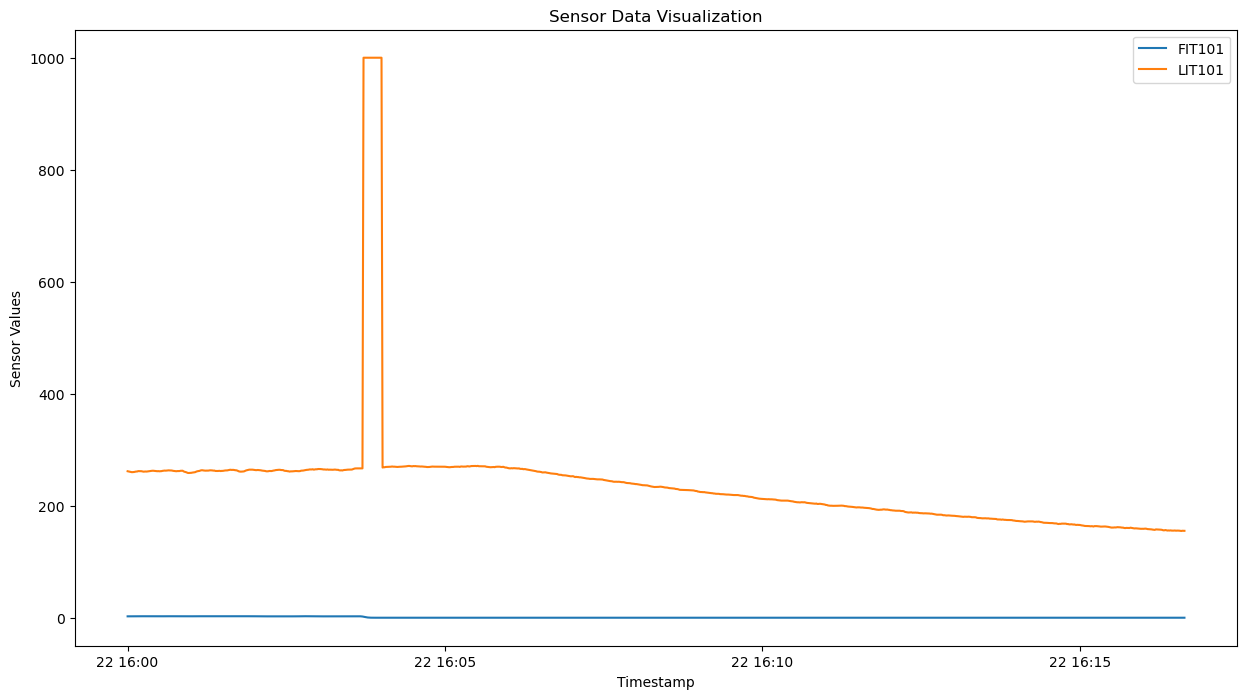

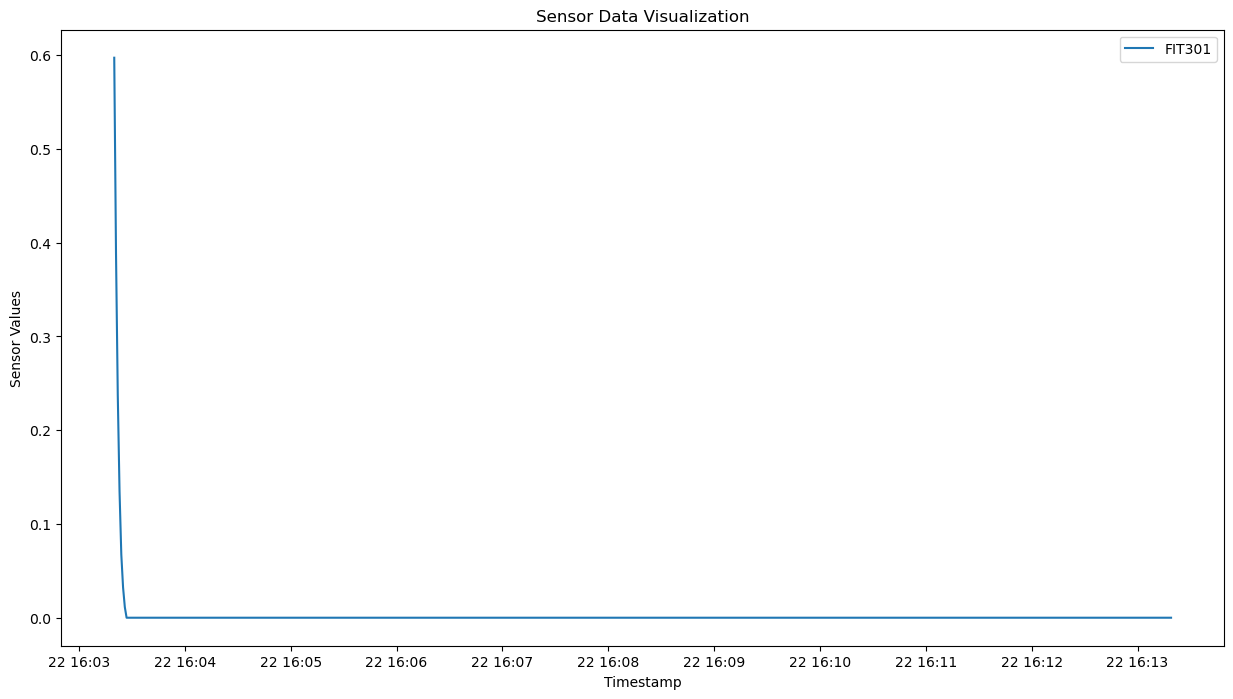

/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


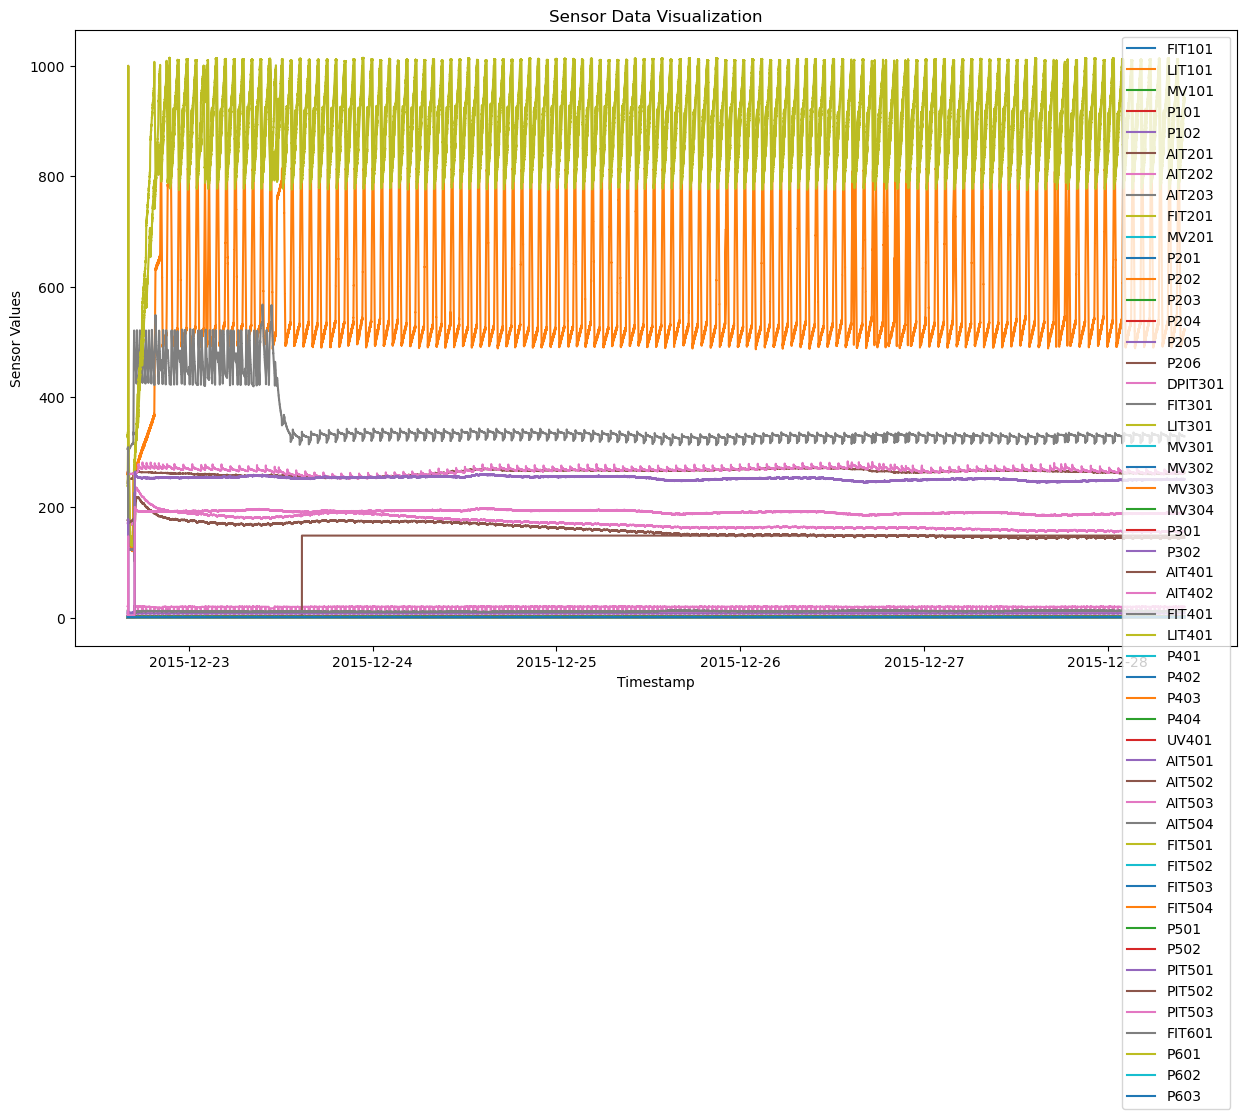

In [99]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
visualize_sensor_data(train_data)

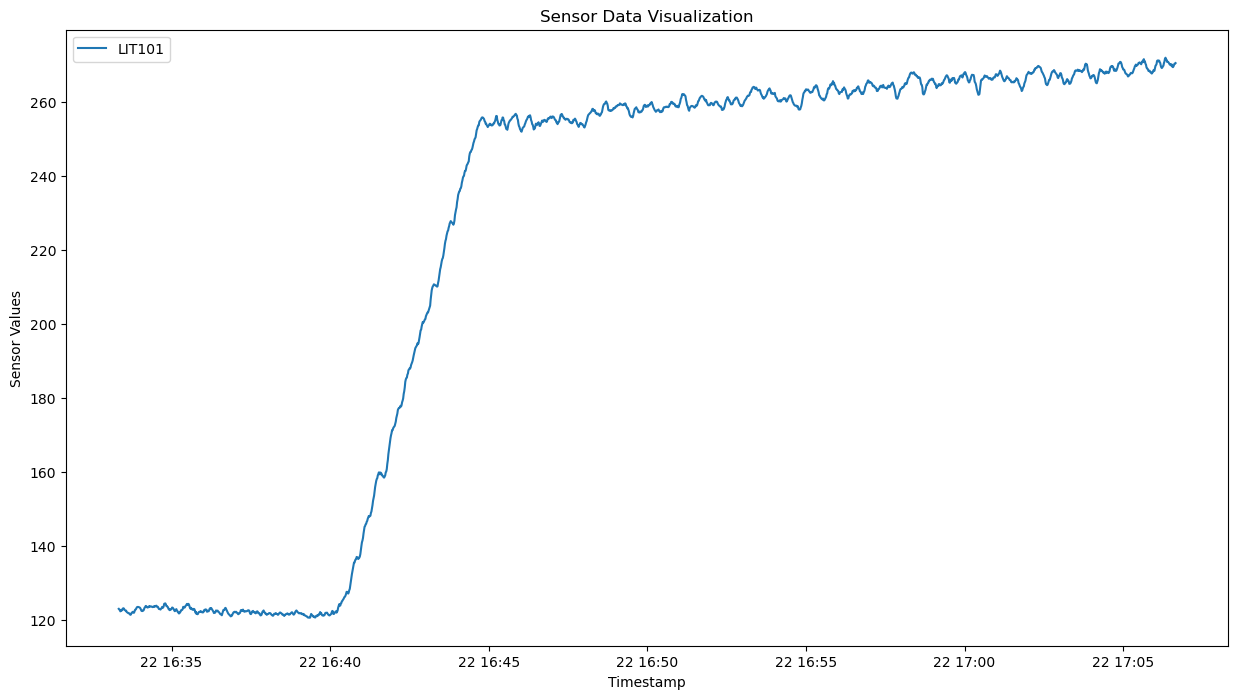

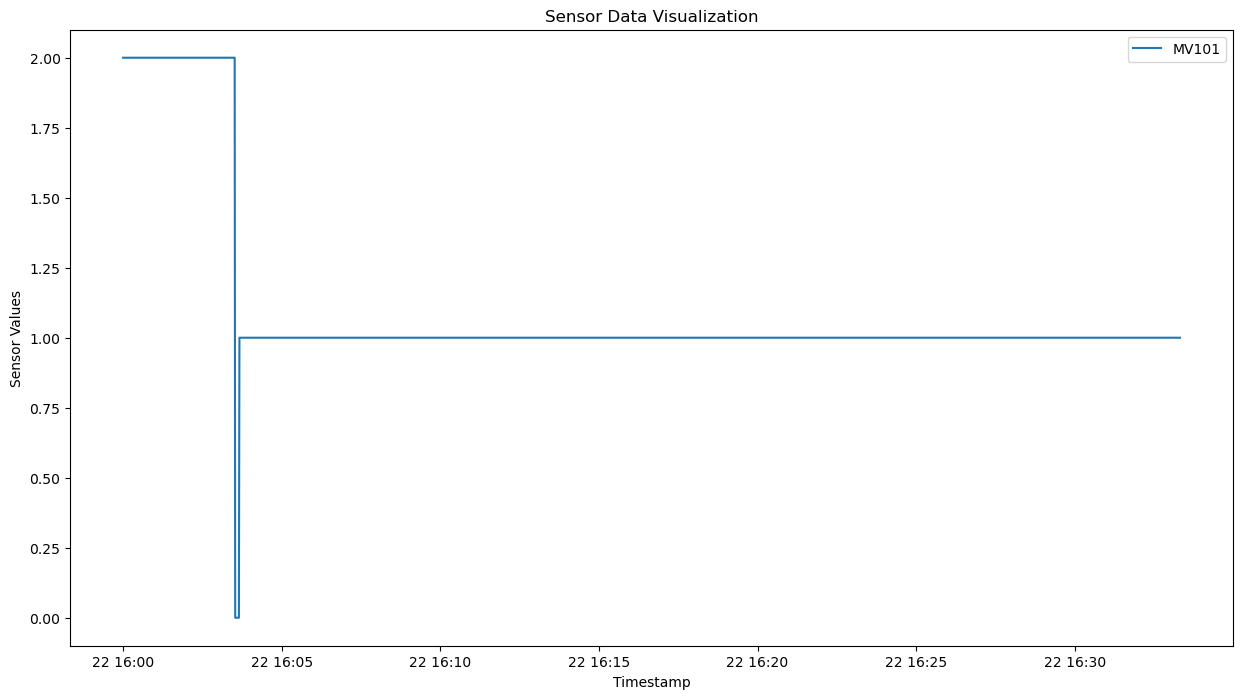

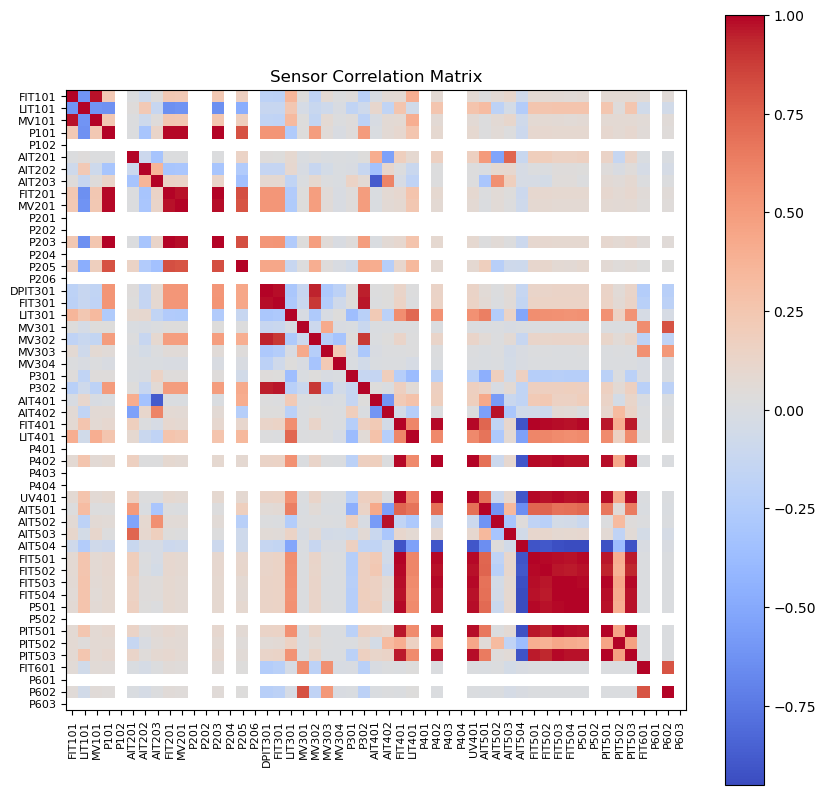

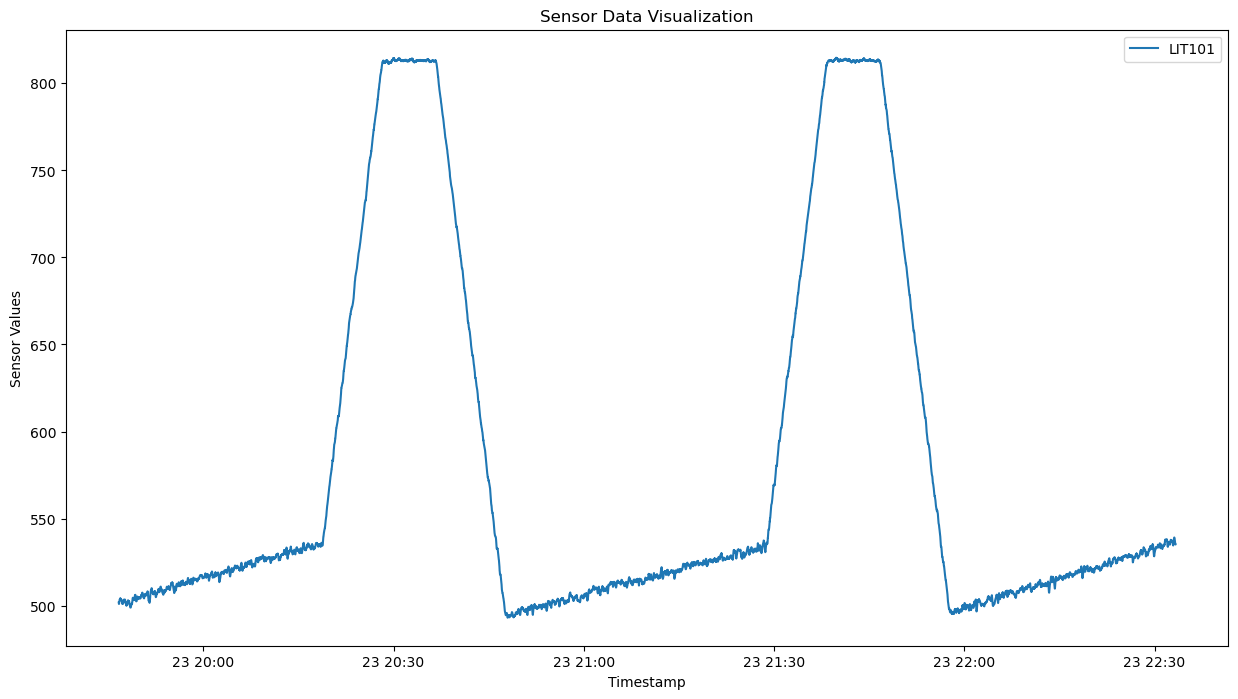

In [100]:
# Familiarization

# 1. What types of signals are there?

# As we observe in the visualisations below, we hace 2 types of signals, continuous (LIT101) and discrete (MV101).

visualize_sensor_data(train_data, window=(2000, 4000), sensors=['LIT101'])
visualize_sensor_data(train_data, window=(0, 2000), sensors=['MV101'])


# 2.a. Are the signals correlated? 

# By visualizing the correlation matrix as a heatmap, 
# we observed distinct clusters of strong correlation (indicated by dark red and dark blue regions).
# We can observe they are strongly correlated.

# For instance, FIT501, FIT502, FIT503, FIT504 and P501.

def plot_correlation_matrix(df):

    # Select only sensor columns 

    sensors = df.iloc[:, 1:-1]
    
    # Calculate correlation using Pandas

    corr = sensors.corr()
    
    # Plot using Matplotlib

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(corr, cmap='coolwarm', interpolation='nearest')
    
    # Add a colorbar (legend)

    fig.colorbar(cax)
    
    # Set ticks to show sensor names

    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8)
    
    plt.title('Sensor Correlation Matrix')
    plt.show()

plot_correlation_matrix(train_data)
    
# 2.b. Do they show cyclic behavior?
    
# As observed, they do show cyclic behaviour, for instance sensor 'LIT101'.
    
visualize_sensor_data(train_data, window=(100000, 110000), sensors=['LIT101'])

In [101]:
def pca_based_anomaly_detection_assess(train_data):    

    # 0. Plot training data and explain startup spikes 

    # We need ot remove the warm up / start up phase of the sensors, as although they are part of normal process that the sensors
    # go through they do not need to be included as normal physical rules the model needs to assume as normal as it will affect 
    # calculations and rules of normal status.

    print("\nWe will start by visualising the data to understand the overall structure.\n") 
    visualize_sensor_data(train_data)
    print("\nWe observe there are signals at the start that are not stabilised, we must remove them for the training of parameters.\n") 


We plot the residual errors to visualise there is a startup spike.



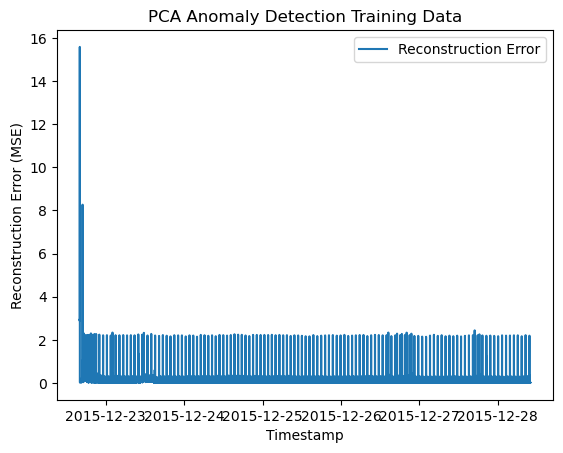


We can visually assess the startup and determine cuttoff at index 85000.



/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


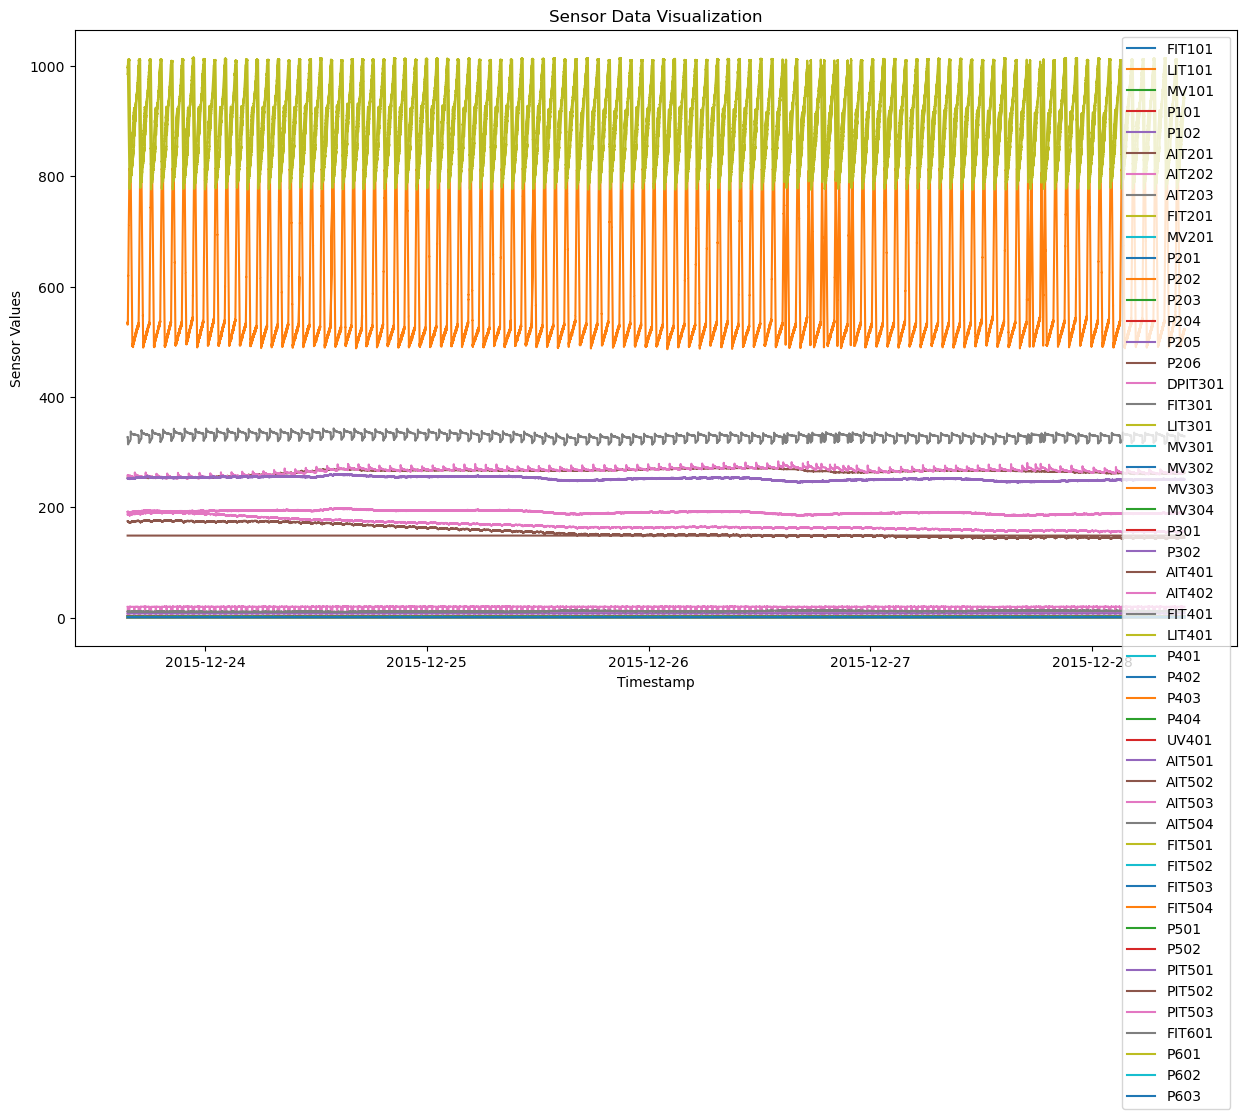


We can now observe the new clean training data.



In [102]:
### PCA-based anomaly detection

def pca_based_anomaly_detection_training(train_data):

    # 1. Determine the mean and stds (excluding the timestamps)

    sensors_train = train_data.iloc[:,1:-1]
    mean_train = np.mean(sensors_train,axis=0)
    std_train = np.std(sensors_train, axis=0)

    # 2. Standardise the data

    standardised_train = (sensors_train - mean_train) / std_train

    # 3. Calculate covariance matrix 

    cov_train = np.cov(standardised_train.T)
    
    # 4. Obtain k most significant eigenvectors that represent 95% of variance

    eigenvalues, eigenvectors = np.linalg.eig(cov_train)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[sorted_indices]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]

    total_sum = np.sum(eigenvalues)
    cut_index = np.argmax(np.cumsum(eigenvalues_sorted)/total_sum>0.95)
    k_train = cut_index + 1

    eigenvectors_k = eigenvectors_sorted[:, :k_train]

    # 5. Compress and reconstruct the data

    compressed_train = np.dot(standardised_train, eigenvectors_k)
    reconstructed_train = np.dot(compressed_train, eigenvectors_k.T)

    # 6. Calculate MSE for standardised and reconstructed error and plot

    mse = np.mean((standardised_train - reconstructed_train) ** 2, axis=1)

    print("\nWe plot the residual errors to visualise there is a startup spike.\n") 
    plt.plot(train_data['Timestamp'][:], mse[:], label='Reconstruction Error')
    plt.xlabel('Timestamp')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title('PCA Anomaly Detection Training Data')
    plt.legend()
    plt.show()

    # 7. Determine cuttoff index of startup where error stabilises and plot to show data is now pure

    print("\nWe can visually assess the startup and determine cuttoff at index 85000.\n") 
    cuttoff = 85000
    clean_data = train_data.iloc[cuttoff:,:]
    visualize_sensor_data(clean_data)
    sensors_clean = clean_data.iloc[:,1:-1]
    print("\nWe can now observe the new clean training data.\n") 

    # 8. Redetermine  means and stds with valid data

    mean_clean = np.mean(sensors_clean, axis=0)
    stds_clean = np.std(sensors_clean, axis=0)

    return mean_clean, stds_clean, cuttoff

mean, stds, cuttoff = pca_based_anomaly_detection_training(train_data)



We plot the average MSE per k components.



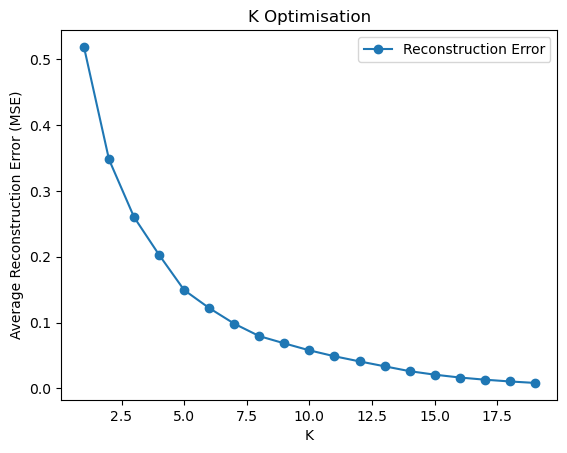


We identify sweet spot at k = 6.



In [103]:
def pca_based_anomaly_detection_optimal_k(train_data, mean, stds, cuttoff):

    # 9. Calculate covariance matrix, eigenvectors and eigenvalues for clean data

    clean_data = train_data.iloc[cuttoff:,:]
    sensors_clean = clean_data.iloc[:,1:-1]

    # 10. Standardise the data

    standardised_clean = (sensors_clean - mean) / stds

    # 11. Calculate covariance matrix 

    cov_clean = np.cov(standardised_clean.T)
    
    # 12. Test different values for k

    eigenvalues, eigenvectors = np.linalg.eig(cov_clean)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]
    mses = []

    for k_test in range(1,20):

        eigenvectors_k = eigenvectors_sorted[:, :k_test]
        compressed_k = np.dot(standardised_clean, eigenvectors_k)
        reconstructed_k = np.dot(compressed_k, eigenvectors_k.T)
        mse_k = np.mean((standardised_clean - reconstructed_k) ** 2, axis=1)
        mses.append(np.mean(mse_k))

    # 13. Plot average mse for different k possible values and select k
        
    print("\nWe plot the average MSE per k components.\n") 
    plt.plot(range(1,20), mses[:], marker='o', label='Reconstruction Error')
    plt.xlabel('K')
    plt.ylabel('Average Reconstruction Error (MSE)')
    plt.title('K Optimisation')
    plt.legend()
    plt.show()
    
    print("\nWe identify sweet spot at k = 6.\n") 
    k = 6

    # We obtained the optimal k
    eigenvectors_k = eigenvectors_sorted[:, :6]

    # Model Tuning is completed

    return eigenvectors_k

eigenvectors_k = pca_based_anomaly_detection_optimal_k(train_data, mean, stds, cuttoff)


In [104]:
# We load the testing data

test_file_path = 'lab1_test.csv'
test_data = pd.read_csv(test_file_path, delimiter=',')
# Convert Timestamp column to datetime
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


We plot the residual errors to obtain the threshold.



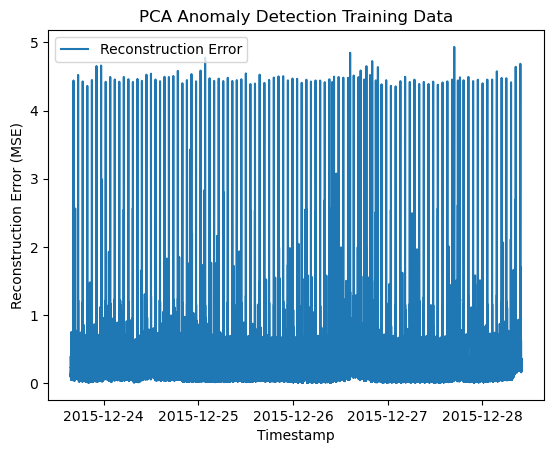


We determine to expect a threshold of 5.



In [105]:
def pca_based_anomaly_detection_threshold(train_data, cuttoff, mean, stds, eigenvectors_k):

    # We will obtain the threshold of the MSE from the clean training data

    clean_data = train_data.iloc[cuttoff:,1:-1]
    clean_timestamps = train_data.iloc[cuttoff:, 0]
    standardised_clean = (clean_data - mean) / stds

    compressed_clean = np.dot(standardised_clean, eigenvectors_k)  
    reconstructed_clean = np.dot(compressed_clean, eigenvectors_k.T)

    mse_clean = np.mean((standardised_clean - reconstructed_clean) ** 2, axis=1)

    print("\nWe plot the residual errors to obtain the threshold.\n") 
    plt.plot(clean_timestamps, mse_clean[:], label='Reconstruction Error')
    plt.xlabel('Timestamp')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title('PCA Anomaly Detection Training Data')
    plt.legend()
    plt.show()

    print("\nWe determine to expect a threshold of 5.\n") 
    threshold = 5

    return threshold

threshold = pca_based_anomaly_detection_threshold(train_data, cuttoff, mean, stds, eigenvectors_k)


Lets visualise the test data.


As test sets usually contain heavy noise compared to training sets, we will manually update this to 13.


We plot the residual errors to detect anomalies in the test data.



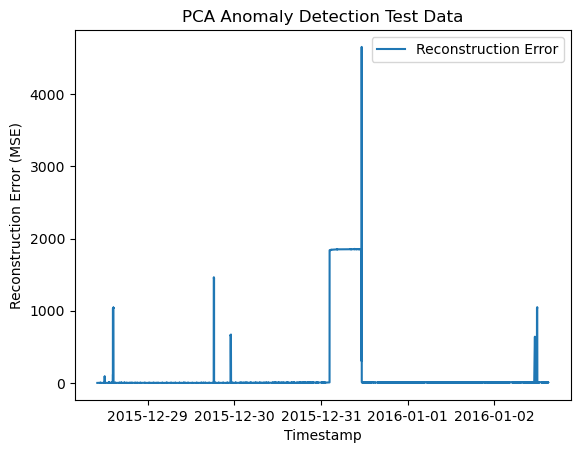


Lets zoom in.



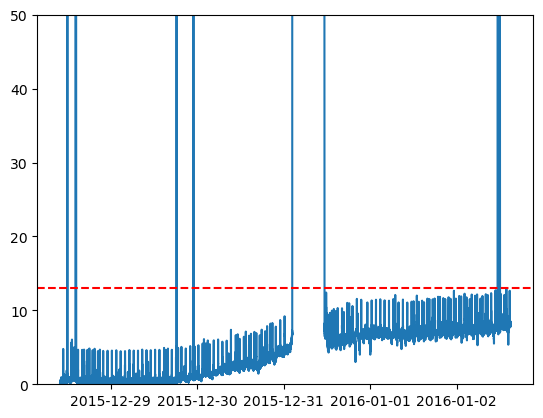


Clearly there are some anomalies in the data.


There have been 35180 anomalies detected in the test set.


In [106]:
def pca_based_anomaly_detection(test_data, mean, stds, eigenvectors_k, threshold):

    # We will now apply it to the test data

    # Increasing k would risk overfitting the model to the point where it reconstructs anomalies as normal behavior. 
    # Therefore, we maintain the optimal k derived from training and adjust the detection threshold to account for 
    # the operational drift observed in the test environment. 

    # This completes the requirement of minimising false alarms (ignoring the drift) while detecting the major deviations.

    print("\nAs test sets usually contain heavy noise compared to training sets, we will manually update this to 13.\n") 
    threshold = 13

    # We expect to detect multivariate anomalies (correlation violations). 
    # For example, if Sensor A and Sensor B usually rise together, but suddenly Sensor A rises while Sensor B stays flat, 
    # PCA will flag this as an anomaly because it violates the "normal" vector direction, even if the individual values 
    # are within normal min/max ranges.

    # 14. Standardise the test data
    test_data.columns = test_data.columns.str.strip()
    sensors_test = test_data.iloc[:,1:-1]

    # Prevent division by near-zero standard deviations
    stds[stds < 1e-10] = 1.0
    standardised_test = (sensors_test - mean) / (stds)

    # 15. Compress and reconstruct

    compressed_test = np.dot(standardised_test, eigenvectors_k)
    reconstructed_test = np.dot(compressed_test, eigenvectors_k.T)

    # 16. Calculate MSE and plot

    mse = np.mean((standardised_test - reconstructed_test) ** 2, axis=1)
    
    print("\nWe plot the residual errors to detect anomalies in the test data.\n") 
    plt.plot(test_data['Timestamp'][:], mse[:], label='Reconstruction Error')
    plt.xlabel('Timestamp')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title('PCA Anomaly Detection Test Data')
    plt.legend()
    plt.show()

    print("\nLets zoom in.\n") 
    plt.plot(test_data['Timestamp'][:], mse[:])
    plt.ylim(0, 50) # Zoom in to the bottom
    plt.axhline(y=threshold, color='r', linestyle='--') # Show your current threshold
    plt.show()

    print("\nClearly there are some anomalies in the data.\n") 
    anomalies_detected = test_data[mse>threshold].shape[0]
    print("\nThere have been", anomalies_detected, "anomalies detected in the test set.")

    # Explain 
    
    return

print("\nLets visualise the test data.\n") 
#visualize_sensor_data(test_data)

pca_based_anomaly_detection(test_data, mean, stds, eigenvectors_k, threshold)